# Second db

In [1]:
IMG_SIZE = 480

RESIZE_SIZE = 128

import torch
from PIL import Image

In [2]:
!pip install cairosvg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.9 MB/s eta 0:00:00


In [3]:
import shutil
import os

save_dir = "/content/saved_knots/"
try:
  shutil.rmtree(save_dir)
except:
  pass

try:
    os.makedirs(save_dir)
except FileExistsError:
    print(f"One or more directories in '{save_dir}' already exist.")
except PermissionError:
    print(f"Permission denied: Unable to create '{save_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")

save_dir = "/content/new_knots_svg/"
try:
  shutil.rmtree(save_dir)
except:
  pass

try:
    os.makedirs(save_dir)
except FileExistsError:
    print(f"One or more directories in '{save_dir}' already exist.")
except PermissionError:
    print(f"Permission denied: Unable to create '{save_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")

save_dir = "/content/new_knots_png/"
try:
  shutil.rmtree(save_dir)
except:
  pass

try:
    os.makedirs(save_dir)
except FileExistsError:
    print(f"One or more directories in '{save_dir}' already exist.")
except PermissionError:
    print(f"Permission denied: Unable to create '{save_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")

In [4]:
def is_in_neighbourhood(x: tuple, y: tuple, epsilon: tuple):
  for i in range(len(x)):
    if (abs(x[i] - y[i]) > epsilon[i]):
      return False
  return True

In [5]:
# db from https://prideout.net/blog/svg_knots
import urllib.request
import cairosvg
from PIL import Image
import PIL.ImageOps
import numpy as np
from skimage.morphology import skeletonize
from skimage.transform import resize
from skimage.util import invert
import matplotlib.pyplot as plt

knots_count_1 = [1, 0, 0, 1, 1, 2, 3, 7, 21, 49, 3] # number of knots with i crossings represented on the https://prideout.net/blog/svg_knots/knottable_v1.svg

import zipfile
import shutil

save_dir = "/content/new_knots_png/"
try:
  shutil.rmtree(save_dir)
except:
  pass

with zipfile.ZipFile(f"/content/knots_aug_4096_resized.zip","r") as zip_ref:
      zip_ref.extractall("/content")

# structure of .zip archive (for now) is archive.zip/content/saved_knots/, so after unpacking it we get /content/content/saved_knots dir, which is not comfortable to work with,
shutil.move("/content/content/new_knots_png", "/content") # so we move it 'higher' one level
shutil.rmtree("/content/content") # and delete previous one

In [6]:
import torchvision.transforms as transforms

def png_to_tensor(path : str =None, png_image : Image =None) -> torch.Tensor:
  if(path != None):
    png_image = Image.open(path)
  transform = transforms.PILToTensor()
  return transform(png_image)

def tensor_to_png(tensor_image) -> Image:
  transform = transforms.ToPILImage()
  return transform(tensor_image)

In [7]:
IMG_SIZE = RESIZE_SIZE

In [8]:
knots_count = knots_count_1.copy()

In [9]:
# apply first transforms to "nonlinearity"
import numpy as np
import skimage as ski
from torchvision.transforms import v2
import os

fill_color = (0, 162, 232)

for file in os.listdir("/content/new_knots_png"):
  img = Image.open(f"/content/new_knots_png/{file}").convert('L')
  pixels = img.load()
  for x in range(IMG_SIZE):
    for y in range(IMG_SIZE):
      if pixels[x, y] < 225:
        pixels[x, y] = 0
      else:
        pixels[x, y] = 255

  img.convert('RGB').save(f"/content/new_knots_png/{file}")

  img = png_to_tensor(f"/content/new_knots_png/{file}")
  perspective_transformer = v2.RandomPerspective(distortion_scale=0.6, p=1.0, fill=fill_color)
  img = perspective_transformer(img)
  tensor_to_png(img).convert("RGB").save(f"/content/new_knots_png/{file}")

  img = Image.open(f"/content/new_knots_png/{file}").convert('RGB')
  pixels = img.load()
  border = []
  for i in range(IMG_SIZE):
    border.append((0, i))
    border.append((i, 0))

  for x in range(1, IMG_SIZE-1):
    for y in range(1, IMG_SIZE-1):
      if (pixels[x-1, y-1] != fill_color or pixels[x-1, y] != fill_color or pixels[x-1, y+1] != fill_color or
         pixels[x, y-1] != fill_color or pixels[x, y+1] != fill_color or
         pixels[x+1, y-1] != fill_color or pixels[x+1, y] != fill_color or pixels[x+1, y+1] != fill_color) and pixels[x, y] == fill_color:
        border.append((x, y))

  for (x, y) in border:
    for c1 in range(-1, 2, 1):
      for c2 in range(-1, 2, 1):
        if (x+c1 >= 0 and x+c1 < IMG_SIZE) and (y+c2 >= 0 and y+c2 < IMG_SIZE):
          pixels[x+c1, y+c2] = fill_color

  for x in range(IMG_SIZE):
    for y in range(IMG_SIZE):
      if pixels[x, y] == fill_color:
        pixels[x, y] = (255, 255, 255)

  img.convert('RGB').save(f"/content/new_knots_png/{file}")

In [10]:
# apply transforms to them!
import math
import random

# numbers of available transformations
k = 3

# max number of times of transforms
MAX_N = max(knots_count) # n(0) = max; N(0) = 1; n(11) = 1; N(11) = knots_count[11] => from formula obtain MAX_N = knots_count[11]; prev was 2**k

def save_transforms(filename, orig_dir):
  try:
    orig_img = png_to_tensor(path=orig_dir + filename + ".png")
  except Exception as e:
    print(f"Error: {e}")
    return

  # see https://pytorch.org/vision/0.20/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

  # random rotation
  rotater = v2.RandomRotation(degrees=(0, 180), expand=False, fill=255)

  # horizontal flip
  hflipper = v2.RandomHorizontalFlip(p=1)

  # vertical flip
  vflipper = v2.RandomVerticalFlip(p=1)

  list_of_transforms = torch.nn.ModuleList([rotater, hflipper, vflipper])

  # create and save the results
  save_dir = f"/content/saved_knots/{filename.split('_')[0]}"
  try:
      os.makedirs(save_dir)
  except FileExistsError:
      print(f"One or more directories in '{save_dir}' already exist.")
  except PermissionError:
      print(f"Permission denied: Unable to create '{save_dir}'.")
      return
  except Exception as e:
      print(f"An error occurred: {e}")
      return

  # uniformly distributed transformations

  # variables
  m = int(filename.split('_')[0])
  N = knots_count[m]
  n = max(1, round(MAX_N/N))
  s = [0]*k
  in_s = []
  a = [math.ceil(n/2)]*k
  b = [math.floor(n/2)]*k

  for i in range(n):
    # set bits of s
    for j in range(k):
      rand_choice = random.randint(1, a[j]+b[j])
      if rand_choice <= a[j]:
        s[j] = 0
        a[j] -= 1
      else:
        s[j] = 1
        b[j] -= 1
    in_s.append(int(''.join(str(j) for j in s), 2))

    cur_img = orig_img
    # for clarity of the image
    if(s[0] or s[2]):
      if(s[0]): cur_img = list_of_transforms[0](cur_img)
      if(s[2]): cur_img = list_of_transforms[2](cur_img)

    for j in range(1, k):
      if s[j] and j != 2:
        cur_img = list_of_transforms[j](cur_img)

    tensor_to_png(cur_img).convert('L').save(save_dir + f"/{len(os.listdir(save_dir))}.png", "png")
    saved_imgs.append(save_dir + f"/{len(os.listdir(save_dir))-1}.png")

In [11]:
directory = os.fsencode("/content/new_knots_png")

# set -{number of knots you want to transform}
N = 1

saved_imgs = []

# aka for knot_image in knots: save transforms of image
for file in os.listdir(directory):
    if(not N): break; N += 1
    filename = os.path.splitext(os.fsdecode(file))[0]
    save_transforms(str(filename), "/content/new_knots_png/")

One or more directories in '/content/saved_knots/9' already exist.
One or more directories in '/content/saved_knots/9' already exist.
One or more directories in '/content/saved_knots/9' already exist.
One or more directories in '/content/saved_knots/9' already exist.
One or more directories in '/content/saved_knots/9' already exist.
One or more directories in '/content/saved_knots/9' already exist.
One or more directories in '/content/saved_knots/9' already exist.
One or more directories in '/content/saved_knots/8' already exist.
One or more directories in '/content/saved_knots/8' already exist.
One or more directories in '/content/saved_knots/9' already exist.
One or more directories in '/content/saved_knots/7' already exist.
One or more directories in '/content/saved_knots/7' already exist.
One or more directories in '/content/saved_knots/9' already exist.
One or more directories in '/content/saved_knots/9' already exist.
One or more directories in '/content/saved_knots/9' already ex

In [12]:
for dir in os.listdir("/content/saved_knots"):
  num = len(os.listdir(f"/content/saved_knots/{dir}"))
  for file_num in range(num):
    filename = f"{file_num}.png"
    for i in range(1, 21, 1):
      img = v2.Resize((IMG_SIZE-2*i, IMG_SIZE-2*i))(png_to_tensor(f"/content/saved_knots/{dir}/{filename}"))
      img = v2.Pad(padding=i, fill=255)(img)
      tensor_to_png(img).convert('L').save(f"/content/saved_knots/{dir}/{num - 1 + file_num*20 + i}.png", "png")
      saved_imgs.append(f"/content/saved_knots/{dir}/{num - 1 + file_num*20 + i}.png")

In [13]:
import zipfile

# save all to the .zip file
with zipfile.ZipFile("knots_aug.zip", "w") as saved_imgs_arch:
    for imgname in saved_imgs:
      saved_imgs_arch.write(imgname)

# Networks

You can start this section by uploading previously zip archive in /content

## Preparation

In [60]:
# extract .zip
import zipfile
import shutil # deletes /content/content directory
import glob # searches for .zip files

try:
  shutil.remove("/content/saved_knots")
except Exception as e:
  pass

# get all .zip files from local storage
files = glob.glob('*.zip')

# if 2 or more files occured, we don't know which we want to extract
if len(files) > 1:
  print("Don't know which archive to unpack")
else:
  # unpack .zip
  with zipfile.ZipFile(f"/content/{files[0]}","r") as zip_ref:
      zip_ref.extractall("/content")

  # structure of .zip archive (for now) is archive.zip/content/saved_knots/, so after unpacking it we get /content/content/saved_knots dir, which is not comfortable to work with,
  shutil.move("/content/content/saved_knots", "/content/saved_knots") # so we move it 'higher' one level
  shutil.rmtree("/content/content") # and delete previous one

Don't know which archive to unpack


In [61]:
import torch
from PIL import Image

IMG_SIZE = 128

In [62]:
# we use torchvision.datasets.ImageFolder class to divide our data into classes and work with them efficiently
# useful links: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
#
#               https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

import torchvision
data_transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                     torchvision.transforms.ToTensor()])
data = torchvision.datasets.ImageFolder(root='/content/saved_knots',
                                        transform=data_transform)

In [63]:
# shape of the element of the data array
image = data[0][0]
image.shape

torch.Size([1, 128, 128])

In [64]:
# split data into train and test sets
k = 0.8 # train/all ratio
train_len = int(k*len(data))
train_data, test_data = torch.utils.data.random_split(data, [train_len, len(data)-train_len])

In [142]:
from torch.utils.data import DataLoader # iterable class; https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 64

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ea5a0970510>, <torch.utils.data.dataloader.DataLoader object at 0x7ea5a0ab6e50>)
Length of train dataloader: 114 batches of 64
Length of test dataloader: 1811


In [202]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 1, 128, 128]), torch.Size([64]))

Image size: torch.Size([1, 128, 128])
Label: 3, label size: torch.Size([])
['0', '10', '3', '4', '5', '6', '7', '8', '9']


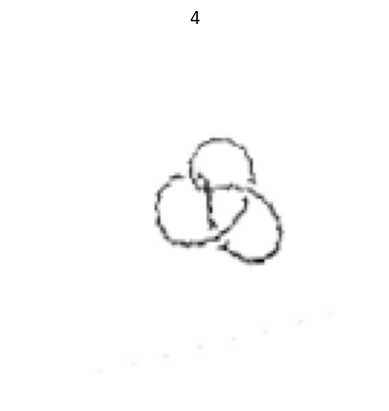

In [203]:
# show a sample
import matplotlib.pyplot as plt

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(data.classes[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")
print(data.classes)

In [68]:
# device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu" # cuda is MUCH faster
device

'cuda'

In [69]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


## Vanila

In [248]:
from torch import nn

# Create a model with non-linear and linear layers
class KnotsModelVanila(nn.Module):
    def __init__(self, input_shape: int, hidden_units_1: int, hidden_units_2: int, hidden_units_3:int, hidden_units_4: int, output_shape: int): # try to change the number of hidden layers
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.BatchNorm2d(num_features=1),
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units_1),
            nn.ELU(),
            nn.Linear(in_features=hidden_units_1, out_features=hidden_units_2),
            nn.ELU(),
            nn.Linear(in_features=hidden_units_2, out_features=hidden_units_3),
            nn.ELU(),
            nn.Linear(in_features=hidden_units_3, out_features=hidden_units_4),
            nn.ELU(),
            nn.Linear(in_features=hidden_units_4, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
      return self.layer_stack(x)

In [249]:
model_1 = KnotsModelVanila(input_shape=(IMG_SIZE)**2, # number of input features
    hidden_units_1=500,
    hidden_units_2=600,
    hidden_units_3=200,
    hidden_units_4=50,
    output_shape=1 # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

In [252]:
# standart functions
from helper_functions import accuracy_fn
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.0003) # try to change lr

In [253]:
# aka training loop
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for (X, y) in data_loader:
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X).squeeze(dim=1)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y.type(torch.float32))
        """print(y)
        print(y_pred)
        input()"""
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.round()) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    train_losses.append(train_loss.cpu().detach().numpy())

# aka testing loop
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X).squeeze(dim=1)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y.type(torch.float32))
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.round() # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        test_losses.append(test_loss.cpu().detach().numpy())

In [254]:
# let's try our model
epochs = 9
train_losses, test_losses = [], []
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

Epoch: 0
---------
Train loss: 3.51530 | Train accuracy: 25.36%
Test loss: 1.84549 | Test accuracy: 24.63%

Epoch: 1
---------
Train loss: 0.77797 | Train accuracy: 54.80%
Test loss: 0.44083 | Test accuracy: 68.80%

Epoch: 2
---------
Train loss: 0.17041 | Train accuracy: 83.77%
Test loss: 0.20603 | Test accuracy: 81.34%

Epoch: 3
---------
Train loss: 0.05662 | Train accuracy: 95.11%
Test loss: 0.09203 | Test accuracy: 94.04%

Epoch: 4
---------
Train loss: 0.03447 | Train accuracy: 98.11%
Test loss: 0.08483 | Test accuracy: 95.25%

Epoch: 5
---------
Train loss: 0.02356 | Train accuracy: 99.22%
Test loss: 0.06867 | Test accuracy: 96.58%

Epoch: 6
---------
Train loss: 0.01826 | Train accuracy: 99.63%
Test loss: 0.05886 | Test accuracy: 97.13%

Epoch: 7
---------
Train loss: 0.01597 | Train accuracy: 99.70%
Test loss: 0.05958 | Test accuracy: 96.63%

Epoch: 8
---------
Train loss: 0.01055 | Train accuracy: 99.79%
Test loss: 0.05423 | Test accuracy: 97.29%



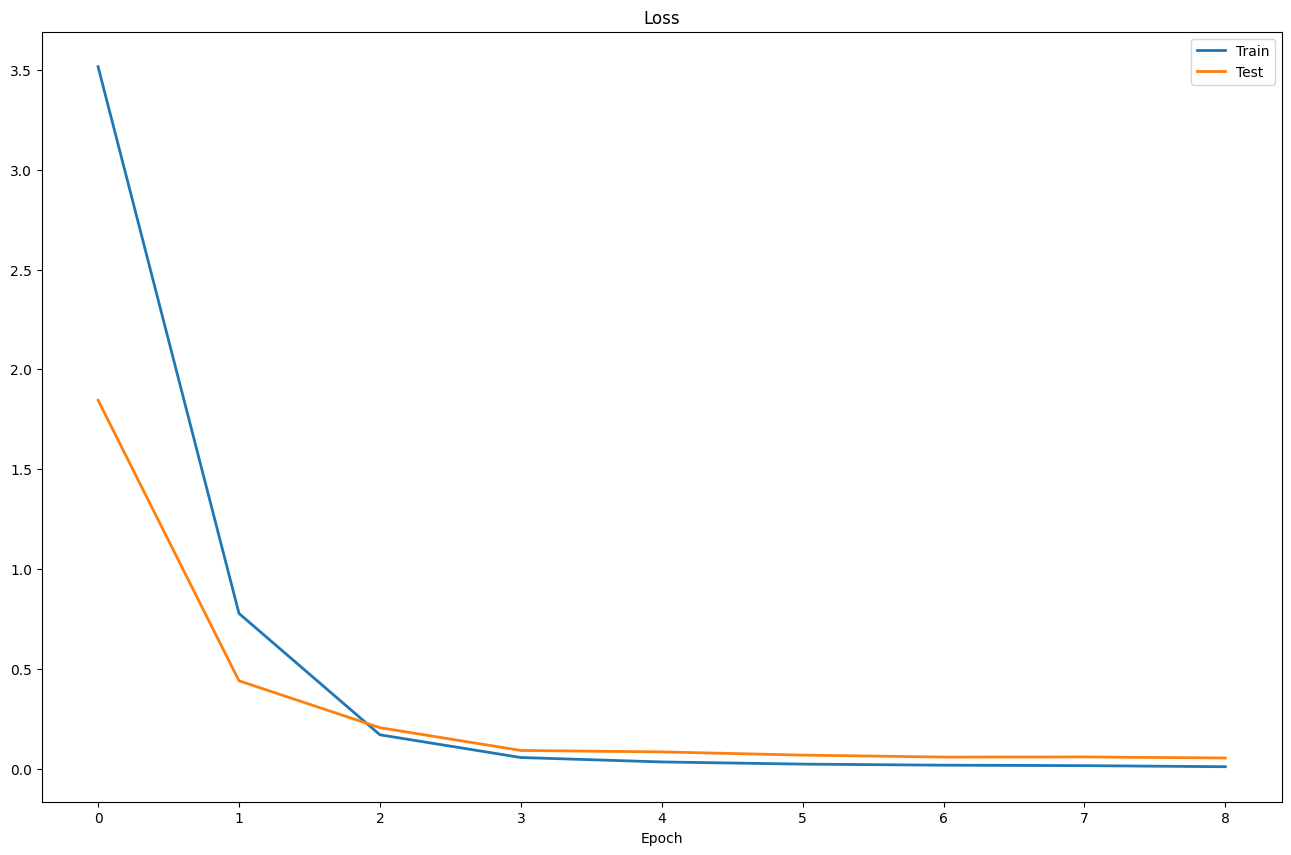

In [255]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
plt.title("Loss")

plt.plot(range(epochs), train_losses, label="Train", linewidth=2)
plt.plot(range(epochs), test_losses, label="Test", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.show()

In [261]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X).squeeze(dim=1)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.round())

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [262]:
# Calculate model 1 results with device-agnostic code
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device
                         )
model_1_results

{'model_name': 'KnotsModelVanila',
 'model_loss': 0.054231733083724976,
 'model_acc': 97.29431253451132}

In [258]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [259]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = KnotsModelVanila(input_shape=(IMG_SIZE)**2, # number of input features
                                  hidden_units_1=500,
                                  hidden_units_2=600,
                                  hidden_units_3=200,
                                  hidden_units_4=50,
                                  output_shape=1 # number of output classes desired
                              ).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
KnotsModelVanila(
  (layer_stack): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=16384, out_features=500, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=500, out_features=600, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=600, out_features=200, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=200, out_features=50, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=50, out_features=1, bias=True)
  )
)
Model on device:
cuda:0


In [263]:
model_1_loaded_results = eval_model(model=loaded_model_1, data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device
                         )
model_1_loaded_results

{'model_name': 'KnotsModelVanila',
 'model_loss': 0.054231733083724976,
 'model_acc': 97.29431253451132}